# PreProcess Data

==>> holton_mass_data_normalized shape: (619400, 75)
==>> holton_mass_input_all: (619399, 76)
==>> State A samples: (324014, 76)
==>> State B samples: (259822, 76)


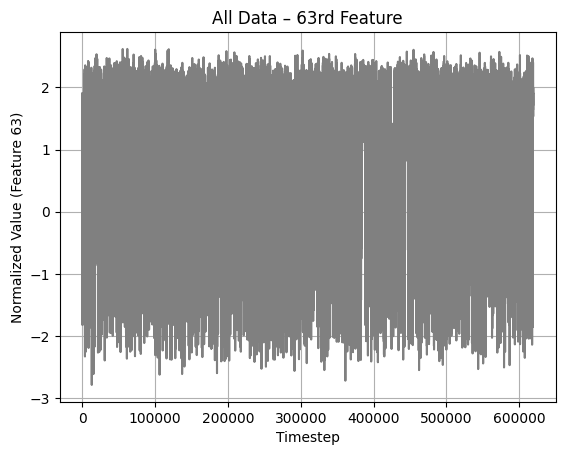

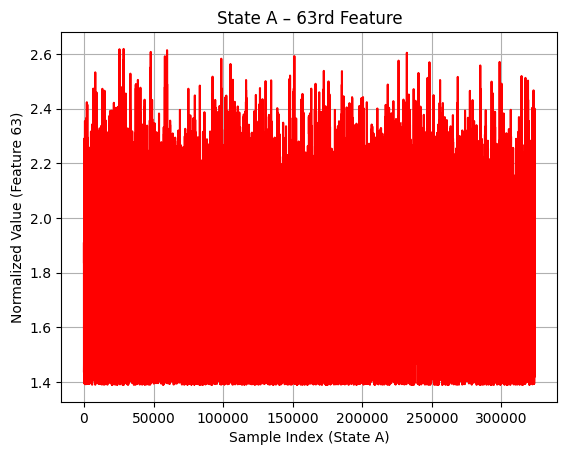

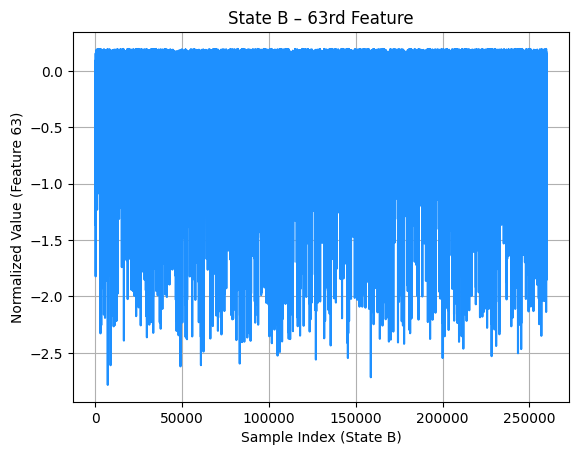

In [118]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from numpy import linalg

holton_mass_data = np.load(r"c:\users\danie\onedrive\desktop\work_torch\long_run_310k.npy")
shape = (holton_mass_data.shape[0] * 2, 75)

holton_mass_data = np.reshape(holton_mass_data, shape)
holton_mass_data_normalized = (holton_mass_data - np.mean(holton_mass_data))  / np.std(holton_mass_data)
print(f"==>> holton_mass_data_normalized shape: {holton_mass_data_normalized.shape}")

lead = 1

# All Data in Both States and Transition Region
holton_mass_input_all =  holton_mass_data_normalized[0:holton_mass_data.shape[0] - lead, :]
holton_mass_label_all = holton_mass_data_normalized[lead:holton_mass_data.shape[0], :]

assert np.all(holton_mass_input_all[100_001, :] == holton_mass_label_all[100_000, :]), "Ensure the input and label data are properly offset by lead"

holton_mass_input_all = np.append(holton_mass_input_all, np.ones((holton_mass_input_all.shape[0], 1)), axis=1)
print(f"==>> holton_mass_input_all: {holton_mass_input_all.shape}")

upper_bound = 18.59 
lower_bound = 7.41

#Data in State A
state_A_indices = np.where(holton_mass_data[:-2, 63] > upper_bound)[0]
holton_mass_input_A = holton_mass_data_normalized[state_A_indices, :]
holton_mass_input_A = np.append(holton_mass_input_A, np.ones((holton_mass_input_A.shape[0], 1)), axis=1)
holton_mass_label_A = holton_mass_data_normalized[state_A_indices+lead, :]
print(f"==>> State A samples: {holton_mass_input_A.shape}")

#Data in State B
state_B_indices = np.where(holton_mass_data[:-2, 63] < lower_bound)[0]
holton_mass_input_B = holton_mass_data_normalized[state_B_indices, :]
holton_mass_input_B = np.append(holton_mass_input_B, np.ones((holton_mass_input_B.shape[0], 1)), axis=1)
holton_mass_label_B = holton_mass_data_normalized[state_B_indices+lead, :]
print(f"==>> State B samples: {holton_mass_input_B.shape}")

plt.figure()
plt.plot(holton_mass_data_normalized[:, 63], color='gray')
plt.title("All Data – 63rd Feature")
plt.xlabel("Timestep")
plt.ylabel("Normalized Value (Feature 63)")
plt.grid(True)

plt.figure()
plt.plot(holton_mass_input_A[:, 63], color='red')
plt.title("State A – 63rd Feature")
plt.xlabel("Sample Index (State A)")
plt.ylabel("Normalized Value (Feature 63)")
plt.grid(True)

plt.figure()
plt.plot(holton_mass_input_B[:, 63], color='dodgerblue')
plt.title("State B – 63rd Feature")
plt.xlabel("Sample Index (State B)")
plt.ylabel("Normalized Value (Feature 63)")
plt.grid(True)

plt.show()


# Find Linear Model Coeffecients

In [112]:
def linear_model_coeffs(X, Y):
    M_bias, resids, rank, singular_values = np.linalg.lstsq(X, Y)
    M = M_bias[:-1, :]
    c = M_bias[-1, :]
    residuals = Y - X @ M_bias
    BBT = residuals.T @ residuals / (residuals.shape[0] - 1)
    return M, c, BBT

# Determine Stationary Distribution

In [113]:
def stationary_distribution (M, c, BBT):
    mu = np.linalg.inv((np.eye(M.shape[0]) - M)) @ c
    gamma = scipy.linalg.solve_discrete_lyapunov(M, BBT)
    return mu, gamma

# Marginal Distributions

In [114]:

def plot_marginal_distributions(feature_indices, mu, gamma, normalized_data):
    num_features = len(feature_indices)
    n_cols = 3  
    n_rows = (num_features + n_cols - 1) // n_cols  

    x = np.linspace(-5, 5, 500)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  

    for i, index in enumerate(feature_indices):
        mean = mu[index]
        std = np.sqrt(gamma[index, index])
        pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))

        empirical_values = normalized_data[:, index]

        ax = axes[i]
        ax.hist(empirical_values, bins=50, density=True, alpha=0.5, label='Holton Mass Empirical', color='dodgerblue')
        ax.plot(x, pdf, color='green', label='Linear Model Gaussian')
        ax.set_title(f"Feature {index+1}")
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.set_yscale('log')
        ax.grid(True)
        ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 1st Linear Model, Evolve Under Data in State A and B

In [116]:
feature_indices = [13, 37, 63]
M, c, BBT = linear_model_coeffs(holton_mass_input_A, holton_mass_label_A)
mu, gamma = stationary_distribution(M, c, BBT)
plot_marginal_distributions(feature_indices, mu, gamma, holton_mass_input_A)

M, c, BBT = linear_model_coeffs(holton_mass_input_B, holton_mass_label_B)
mu, gamma = stationary_distribution(M, c, BBT)
plot_marginal_distributions(feature_indices, mu, gamma, holton_mass_input_B)

17326.04s - name 'array' is not defined
Traceback (most recent call last):
  File "c:\Users\danie\OneDrive\Desktop\work_torch\.venv\Lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_vars.py", line 636, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined. Did you forget to import 'array'?


ValueError: operands could not be broadcast together with shapes (75,75) (75,76) 

# 2nd Linear Model, Evolve Under Data in State A and B

In [ ]:
M, c, BBT = linear_model_coeffs(holton_mass_input_all, holton_mass_label_all)
mu, gamma = stationary_distribution(M, c, BBT)
plot_marginal_distributions(feature_indices, mu, gamma, holton_mass_input_all)